In [1]:
import sys 
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import numpy as np
import pandas as pd
import os

In [2]:
import os

def find_subjects_with_both_rest_files(subjects_dir):
    # List to store subjects with both rest1 and rest2 files
    subjects_with_both_rest_files = []

    # Get a list of all subjects in the directory
    subject_folders = [f for f in os.listdir(subjects_dir) if os.path.isdir(os.path.join(subjects_dir, f))]

    # Loop over each subject folder
    for subject in subject_folders:
        subject_folder = os.path.join(subjects_dir, subject)
        rest1_file = os.path.join(subject_folder, 'restrun1.nii.gz')
        rest2_file = os.path.join(subject_folder, 'restrun2.nii.gz')

        # Check if both rest1 and rest2 files exist
        if os.path.exists(rest1_file) and os.path.exists(rest2_file):
            try:
                # Convert subject to integer and append to the list
                subjects_with_both_rest_files.append(int(subject))
            except ValueError:
                # Skip subjects that cannot be converted to integer
                print(f"Skipping subject {subject} (cannot be converted to integer)")

    return subjects_with_both_rest_files

# Define the subjects directory
subjects_dir = '/pl/active/banich/studies/wmem/fmri/subjects/wmem_results'

# Find subjects with both rest1 and rest2 files
subjects = find_subjects_with_both_rest_files(subjects_dir)

In [3]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')
z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]
z_data = z_data.dropna()

from scipy.stats import zscore
z_data['br_z_ave'] = z_data['z_ave']
z_data.drop('z_ave', axis=1, inplace=True)
z_data['b_z_ave'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']))/3
z_data['thought_problems'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']) + zscore(z_data['RRS_reflection']) + zscore(z_data['RRS_depression']))/5

z_data = z_data[['SubID', 'thought_problems', 'b_z_ave']]

KeyboardInterrupt: 

In [ ]:
#z_data = z_data.query('SubID in @subjects')

In [ ]:
eccentricity = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_eccentricity.csv')

across_network_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_across_network_dispersion.csv')

modularity = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_network_modularity.csv')
op_modularity = modularity.iloc[:, :5]
network_modularity = modularity.drop(op_modularity.iloc[:, 1:].columns, axis=1)

eigcent = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_network_eigcent.csv')
eigcent.columns = eigcent.columns.str.replace('maintain', 'main')

within_network_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_within_network_dispersion.csv')


grad_ranges = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_gradient_range.csv')

In [ ]:
grad_subs = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/all_metrics_z.csv').SubID.to_list()

In [ ]:
all_mets = pd.merge(eccentricity, across_network_disp, on='SubID')
all_mets = pd.merge(all_mets, op_modularity, on='SubID')
all_mets = pd.merge(all_mets, network_modularity, on='SubID')
all_mets = pd.merge(all_mets, within_network_disp, on='SubID')
all_mets = pd.merge(all_mets, grad_ranges, on='SubID')

all_mets['SubID'] = all_mets['SubID'].astype(int)
all_mets = all_mets.query('SubID in @grad_subs')

In [20]:
import sys 

sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import sys 
import os
import glob
import numpy as np
import scipy.io
import pandas as pd

def run_regression(data, target, y_var, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    
    if interaction is not None:
        # Creating the formula with interaction terms if specified
        formula = f'{target[0]} ~ {y_var} * {interaction}'
    else:
        formula = f'{target[0]} ~ {y_var}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list, interaction):
    import pandas as pd

    targets = [['thought_problems'], ['b_z_ave']]

    regression_results = []
    for target in targets:
        for variable in variable_list:
            regression_results.append(run_regression(data, target, variable, interaction))

    output_regressions = pd.concat(regression_results)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions#[['var', 'r2', 'adjr2', 'fstat', 'pval', 'formula']]

In [21]:
predictors = all_mets.iloc[:, 1:].columns.to_list()

def run_regs(data, test_cols, method):
    
    regression_output = regression_function(data, test_cols, interaction=None)
    regression_sig_vars = regression_output.query('pval < .05').formula.to_list()
    regression_full_sig_output = regression_output.query('formula in @regression_sig_vars')
    #regression_full_sig_output.to_csv(f'/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/grapth_theory/regression_outputs/all_op_sig_outputs_{method}.csv', index=False)
    
    return regression_full_sig_output

all_mets_z = pd.merge(z_data, all_mets, on='SubID')
all_mets_z.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/bootstrapped_regressions/data/task/dispersion_metrics_z.csv', index=False)

run_regs(all_mets_z, predictors, 'task').formula.unique()

array(['thought_problems ~ main_dmn_eccentricity',
       'thought_problems ~ replace_smn_dispersion_md',
       'thought_problems ~ suppress_fpcn_dispersion_md',
       'thought_problems ~ clear_dmn_dispersion_md',
       'thought_problems ~ replace_g1', 'thought_problems ~ suppress_g3',
       'thought_problems ~ clear_g3', 'b_z_ave ~ main_dmn_eccentricity',
       'b_z_ave ~ suppress_dmn_eccentricity',
       'b_z_ave ~ main_smn_dmn_disp',
       'b_z_ave ~ suppress_fpcn_dispersion_md', 'b_z_ave ~ maintain_g3',
       'b_z_ave ~ suppress_g3', 'b_z_ave ~ clear_g3'], dtype=object)

In [135]:
import pandas as pd

def network_means(data, net, metric):
    sub = data[['SubID']].copy()
    mean = data.filter(regex=f'{net}').mean(axis=1)

    output = pd.concat([sub, mean], axis=1)
    output.columns = ['SubID', f'{net}_{metric}']
    
    return output

def drop_duplicate_columns(df):
    # Transpose the DataFrame to easily check for duplicate columns
    df_transposed = df.T
    
    # Remove duplicate columns
    df_transposed = df_transposed.drop_duplicates()
    
    # Transpose back to the original DataFrame structure
    df_cleaned = df_transposed.T
    
    return df_cleaned

def get_net_means(data, metric):
    network_outputs = []
    for net in ['vn', 'smn', 'fpcn', 'dmn']:
        network_outputs.append(network_means(data, net, metric))
    
    concatenated = pd.concat(network_outputs, axis=1)
    concatenated = drop_duplicate_columns(concatenated)
    
    concatenated['SubID'] = concatenated['SubID'].astype(int)
    
    # Compute the mean across all original network columns for each subject
    original_columns = data.filter(regex='|'.join(['vn', 'smn', 'fpcn', 'dmn'])).columns
    concatenated[f'total_{metric}'] = data[original_columns].mean(axis=1)
    
    return concatenated

def get_across_net_means(data, metric):
    combinations = [
        'vn_smn', 'vn_fpcn', 'vn_dmn', 'smn_fpcn', 'smn_dmn', 'fpcn_dmn'
    ]

    network_outputs = []
    for combo in combinations:
        network_outputs.append(network_means(data, combo, metric))
    
    concatenated = pd.concat(network_outputs, axis=1)
    concatenated = drop_duplicate_columns(concatenated)
    
    concatenated['SubID'] = concatenated['SubID'].astype(int)
    
    # Compute the mean across all original combination columns for each subject
    original_columns = data.filter(regex='|'.join(combinations)).columns
    concatenated[f'total_{metric}'] = data[original_columns].mean(axis=1)
    
    return concatenated

In [136]:
def get_op_means(data, metric):
    
    op_outputs = []
    for i in ['main', 'replace', 'suppress', 'clear']:
        op_outputs.append(network_means(data, i, metric))

    output = drop_duplicate_columns(pd.concat(op_outputs, axis=1))

    output['SubID'] = output['SubID'].astype(int)
    
    return output

In [137]:
network_modularity_means = get_net_means(network_modularity, 'mod')

within_network_disp_means = get_net_means(within_network_disp, 'within_disp')

across_network_disp_means = get_across_net_means(across_network_disp, 'across_disp')

eigcent_means = get_net_means(eigcent, 'eigcent')

eccentricity_means = get_net_means(eccentricity, 'ecc')

all_network_means = pd.merge(across_network_disp_means, within_network_disp_means, on='SubID')
all_network_means = pd.merge(all_network_means, eccentricity_means, on='SubID')
all_network_means = pd.merge(all_network_means, eigcent_means, on='SubID')
all_network_means = pd.merge(all_network_means, network_modularity_means , on='SubID')

In [138]:
op_network_across_disp_means = get_op_means(across_network_disp, 'across_disp')

op_network_disp_means = get_op_means(within_network_disp, 'within_disp')

op_eigcent_means = get_op_means(eigcent, 'eigcent')

op_eccentricity_means = get_op_means(eccentricity, 'ecc')

all_op_means = pd.merge(op_network_disp_means, op_network_across_disp_means, on='SubID')
all_op_means = pd.merge(all_op_means, op_eccentricity_means, on='SubID')
all_op_means = pd.merge(all_op_means, op_eigcent_means, on='SubID')
all_op_means = pd.merge(all_op_means, op_modularity, on='SubID')

In [139]:
all_metrics = pd.merge(all_network_means, all_op_means, on='SubID')
all_metrics = pd.merge(all_metrics, grad_ranges, on='SubID')

In [140]:
all_metrics_z = pd.merge(all_metrics, z_data, on='SubID')

In [141]:
all_metrics_z.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_all_metrics_z.csv', index=False)

In [142]:
all_metrics_z = all_metrics_z.query('SubID in @subjects')

In [143]:
yeo_cols = ['vn_smn_across_disp', 'vn_fpcn_across_disp',
       'vn_dmn_across_disp', 'smn_fpcn_across_disp', 'smn_dmn_across_disp',
       'fpcn_dmn_across_disp', 'total_across_disp', 'vn_within_disp',
       'smn_within_disp', 'fpcn_within_disp', 'dmn_within_disp',
       'total_within_disp', 'vn_ecc', 'smn_ecc', 'fpcn_ecc', 'dmn_ecc',
       'total_ecc', 'vn_eigcent', 'smn_eigcent', 'fpcn_eigcent', 'dmn_eigcent',
       'total_eigcent', 'vn_mod', 'smn_mod', 'fpcn_mod', 'dmn_mod',
       'total_mod', 'main_within_disp', 'replace_within_disp',
       'suppress_within_disp', 'clear_within_disp', 'main_across_disp',
       'replace_across_disp', 'suppress_across_disp', 'clear_across_disp',
       'main_ecc', 'replace_ecc', 'suppress_ecc', 'clear_ecc', 'main_eigcent',
       'replace_eigcent', 'suppress_eigcent', 'clear_eigcent', 'main_mod',
       'replace_mod', 'suppress_mod', 'clear_mod', 'maintain_g1',
       'maintain_g2', 'maintain_g3', 'replace_g1', 'replace_g2', 'replace_g3',
       'suppress_g1', 'suppress_g2', 'suppress_g3', 'clear_g1', 'clear_g2',
       'clear_g3']

import pandas as pd
from sklearn.preprocessing import power_transform

# Assuming sub_data is your DataFrame and filtered_data is already defined
# filtered_data = sub_data.filter(regex='disp')
# Filter columns based on regex
filtered_data = all_metrics_z[yeo_cols]

# Apply Yeo-Johnson transformation
# Note: power_transform returns a numpy array, so we need to convert it back to a DataFrame
yeo_johnson_transformed_data = pd.DataFrame(power_transform(filtered_data, method='yeo-johnson'), columns=filtered_data.columns)

#yeo_johnson_transformed_data

import numpy as np
from scipy import stats

# Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(yeo_johnson_transformed_data)

print(f"Shapiro-Wilk Test statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

# Interpretation of the result
if shapiro_test.pvalue > 0.05:
    print("The data is likely normal (fail to reject H0)")
else:
    print("The data is likely not normal (reject H0)")
    
all_metrics_z_yeo = pd.concat([all_metrics_z[['SubID', 'thought_problems', 'b_z_ave']], yeo_johnson_transformed_data], axis=1)
#all_metrics_z = all_metrics_z_yeo

Shapiro-Wilk Test statistic: 0.9970123767852783, p-value: 0.0003002701560035348
The data is likely not normal (reject H0)


/projects/jade6100/software/anaconda/envs/jake/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [144]:
def run_regression(data, target, y_vars, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    
    if interaction is not None:
        # Creating the formula with interaction terms if there are multiple y_vars
        if len(y_vars) > 1:
            joined_vars = ' * '.join(y_vars)
        else:
            joined_vars = y_vars[0]
        
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    else:
        joined_vars = ' + '.join(y_vars)
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list, interaction):
    import itertools
    import pandas as pd

    # Given list
    variables = variable_list
    targets = [['thought_problems'], ['b_z_ave']]

    # Create a list to hold all combinations
    all_combinations = []

    # Generate combinations for each length from 1 to min(length of the list, 6)
    for r in range(1, min(len(variables), 5) + 1):
        combinations = list(itertools.combinations(variables, r))
        all_combinations.extend(combinations)

    # Convert each tuple to a list
    list_combinations = [list(item) for item in all_combinations]

    regression_combinations = []
    for i in targets:
        for j in list_combinations:
            regression_combinations.append(run_regression(data, i, j, interaction))

    output_regressions = pd.concat(regression_combinations)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions[['var', 'r2', 'adjr2', 'fstat', 'pval','formula']]

In [145]:
#all_metrics_z.SubID.to_list()

In [146]:
test_cols = ['vn_smn_across_disp', 'smn_fpcn_across_disp', 'vn_fpcn_across_disp', 'fpcn_dmn_across_disp', 
             'vn_dmn_across_disp', 'smn_dmn_across_disp', 'total_across_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [147]:
test_cols = ['main_across_disp', 'replace_across_disp','suppress_across_disp', 'clear_across_disp', 'total_across_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [148]:
test_cols = ['vn_within_disp', 'smn_within_disp', 'fpcn_within_disp', 'dmn_within_disp', 'total_within_disp']
regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05').formula.to_list()

[]

In [149]:
regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [150]:
test_cols = [ 'main_within_disp', 'replace_within_disp', 'suppress_within_disp', 'clear_within_disp', 'total_within_disp']

#regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

In [151]:
test_cols = ['vn_ecc', 'smn_ecc', 'fpcn_ecc', 'dmn_ecc', 'total_ecc']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula
0,thought_problems,0.126,0.101,5.042,0.0312,thought_problems ~ total_ecc
0,b_z_ave,0.130,0.106,5.247,0.0281,b_z_ave ~ total_ecc


In [152]:
test_cols = ['main_ecc', 'replace_ecc', 'suppress_ecc', 'clear_ecc', 'total_ecc']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula
0,thought_problems,0.145,0.121,5.943,0.0200,thought_problems ~ replace_ecc
0,thought_problems,0.141,0.117,5.751,0.0219,thought_problems ~ suppress_ecc
0,thought_problems,0.110,0.084,4.320,0.0451,thought_problems ~ clear_ecc
0,thought_problems,0.126,0.101,5.042,0.0312,thought_problems ~ total_ecc
0,thought_problems,0.169,0.120,3.458,0.0429,thought_problems ~ main_ecc + replace_ecc
0,thought_problems,0.191,0.143,4.011,0.0273,thought_problems ~ main_ecc + total_ecc
0,thought_problems,0.167,0.118,3.416,0.0445,thought_problems ~ replace_ecc + suppress_ecc
0,b_z_ave,0.122,0.097,4.869,0.0340,b_z_ave ~ replace_ecc
0,b_z_ave,0.172,0.148,7.254,0.0108,b_z_ave ~ suppress_ecc
0,b_z_ave,0.130,0.106,5.247,0.0281,b_z_ave ~ total_ecc


In [153]:
test_cols = ['vn_eigcent', 'smn_eigcent','fpcn_eigcent', 'dmn_eigcent', 'total_eigcent']

#regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

In [154]:
test_cols = ['main_eigcent', 'replace_eigcent','suppress_eigcent', 'clear_eigcent', 'total_eigcent']

#regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

In [155]:
test_cols = ['main_mod', 'replace_mod','suppress_mod', 'clear_mod', 'total_mod']

#regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

In [156]:
test_cols = ['vn_mod', 'smn_mod', 'fpcn_mod', 'dmn_mod', 'total_mod']

#regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

In [157]:
test_cols = ['maintain_g3', 'replace_g3', 'suppress_g3', 'clear_g3']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05').sort_values('pval')

,var,r2,adjr2,fstat,pval,formula
0,b_z_ave,0.175,0.152,7.434,0.00993,b_z_ave ~ maintain_g3
0,b_z_ave,0.162,0.138,6.774,0.01350,b_z_ave ~ suppress_g3
0,thought_problems,0.159,0.135,6.601,0.01460,thought_problems ~ suppress_g3
0,b_z_ave,0.207,0.160,4.436,0.01940,b_z_ave ~ maintain_g3 + suppress_g3
0,b_z_ave,0.143,0.118,5.823,0.02120,b_z_ave ~ clear_g3
0,b_z_ave,0.201,0.154,4.285,0.02190,b_z_ave ~ maintain_g3 + clear_g3
0,b_z_ave,0.197,0.150,4.179,0.02380,b_z_ave ~ suppress_g3 + clear_g3
0,thought_problems,0.134,0.110,5.431,0.02570,thought_problems ~ maintain_g3
0,thought_problems,0.131,0.106,5.280,0.02770,thought_problems ~ clear_g3
0,thought_problems,0.188,0.140,3.940,0.02890,thought_problems ~ suppress_g3 + clear_g3


In [158]:
'vn_within_disp', 'smn_within_disp', 'fpcn_within_disp', 'dmn_within_disp', 'total_within_disp', 'total_ecc',
'suppress_g3', 'clear_g3'

('suppress_g3', 'clear_g3')

In [117]:
test_cols = ['vn_within_disp', 'smn_within_disp', 'fpcn_within_disp', 
             'dmn_within_disp', 'total_within_disp', 'total_ecc','suppress_g3', 'clear_g3']

regs = regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

In [118]:
regs.sort_values('pval').sort_values('pval').head(6).formula.to_list()

['thought_problems ~ smn_within_disp + suppress_g3',
 'b_z_ave ~ smn_within_disp + suppress_g3',
 'b_z_ave ~ smn_within_disp + fpcn_within_disp + suppress_g3',
 'thought_problems ~ smn_within_disp + fpcn_within_disp + suppress_g3',
 'b_z_ave ~ suppress_g3',
 'thought_problems ~ suppress_g3']

In [33]:
regs.sort_values('pval').sort_values('pval').head(6)

,var,r2,adjr2,fstat,pval,formula
0,thought_problems,0.312,0.250,4.998,0.00575,thought_problems ~ smn_within_disp + fpcn_with...
0,thought_problems,0.255,0.211,5.821,0.00670,thought_problems ~ smn_within_disp + suppress_g3
0,thought_problems,0.328,0.244,3.910,0.01070,thought_problems ~ smn_within_disp + fpcn_with...
0,thought_problems,0.282,0.217,4.323,0.01120,thought_problems ~ smn_within_disp + total_ecc...
0,thought_problems,0.320,0.235,3.761,0.01280,thought_problems ~ fpcn_within_disp + dmn_with...
0,thought_problems,0.316,0.231,3.701,0.01380,thought_problems ~ smn_within_disp + fpcn_with...


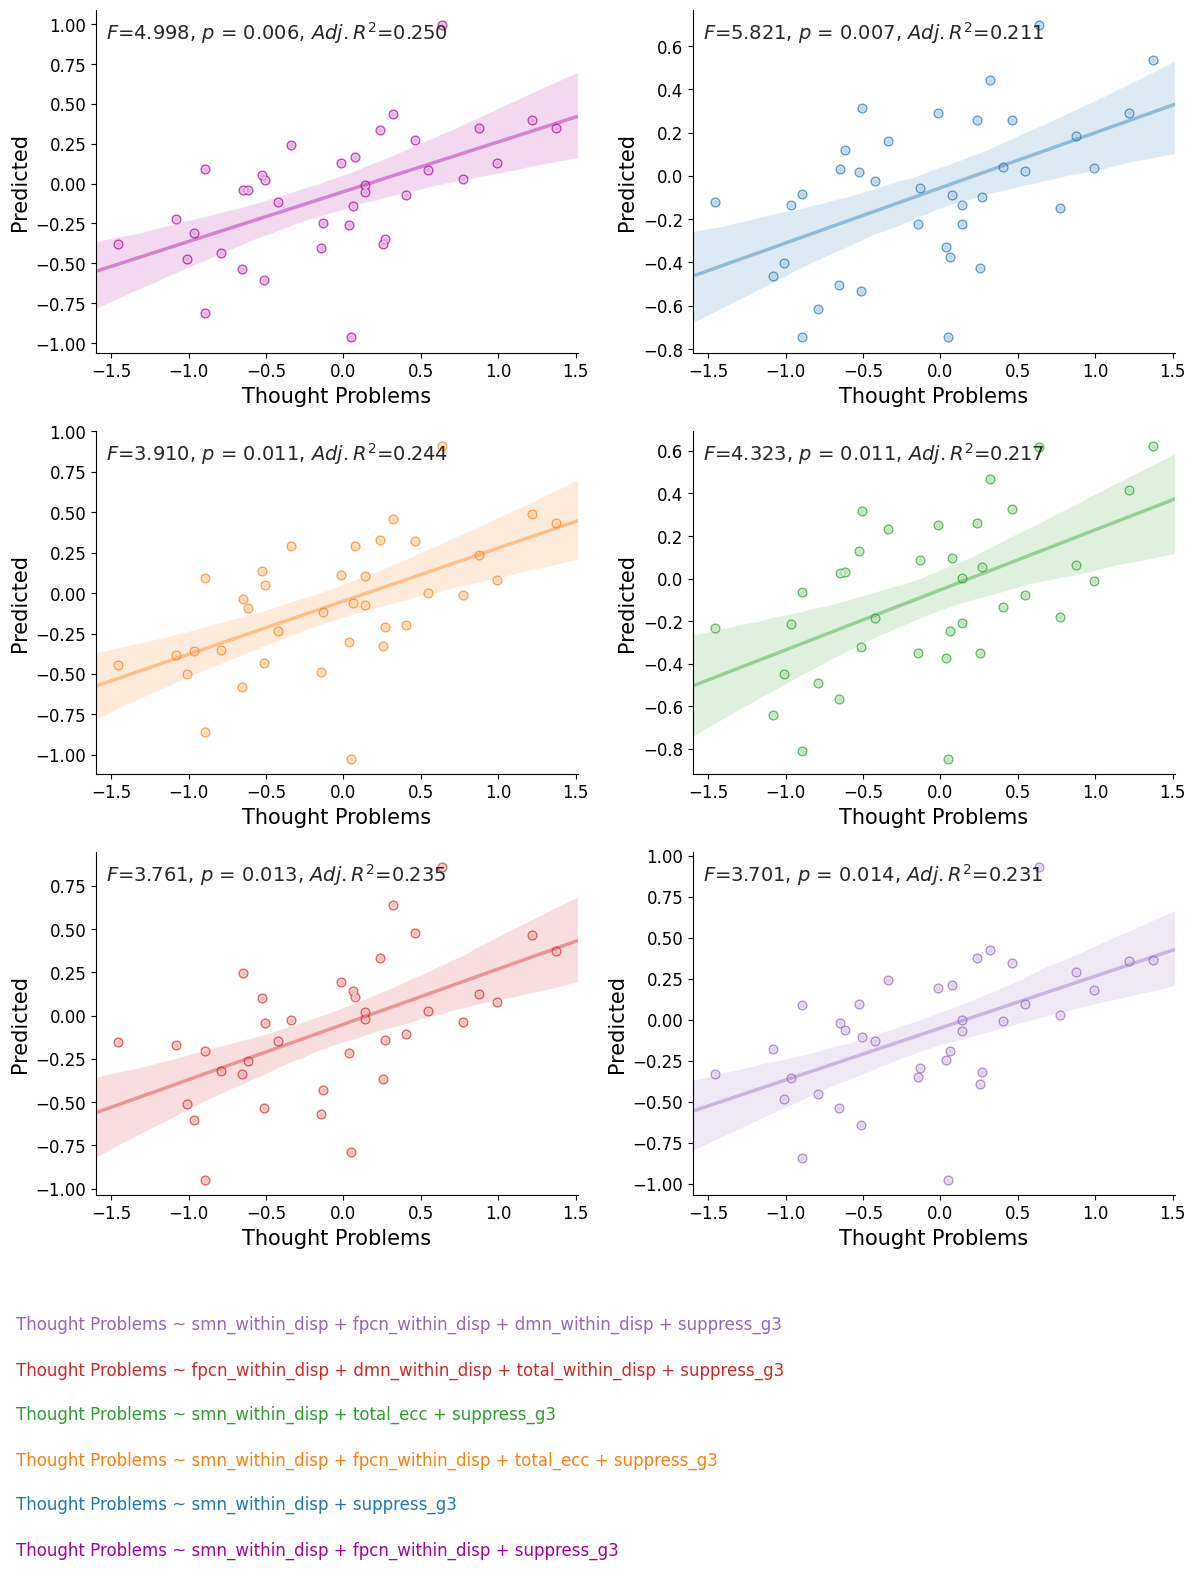

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

def reg_plots(data, x_vars, yvar, color, ax):
    joined_vars = ' + '.join(x_vars)
    formula = f'{yvar[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Store the predicted values in the data
    data['Predicted'] = model.predict()

    # Scatter plot with regression line
    sns.set_theme(style="white")

    # Scatter plot with regression line modifications
    sns.regplot(y='Predicted', x=f'{yvar[0]}', data=data, ci=95,
                color=color, scatter_kws={'s': 40, 'alpha': 0.6}, truncate=False, ax=ax,
                line_kws={'linewidth': 2.5, 'alpha': 0.4})

    sns.regplot(y='Predicted', x=f'{yvar[0]}', data=data, fit_reg=False,
                color='white', scatter_kws={'s': 20, 'alpha': .5}, truncate=False, ax=ax)

    # Set axis labels
    ax.set_xlabel('Thought Problems', fontsize=15)
    ax.set_ylabel('Predicted', fontsize=15)

    # Adding subtitle with F-statistic and p-value using text annotation, with 'p' in italic
    p_value_text = f"< .001" if model.f_pvalue < 0.001 else f"= {model.f_pvalue:.3f}"
    subtitle = f"$\it{{F}}$={model.fvalue:.3f}, $\it{{p}}$ {p_value_text}, $\it{{Adj. R}}^2$={model.rsquared_adj:.3f}"
    ax.text(0.02, .97, subtitle, transform=ax.transAxes, fontsize=14, verticalalignment='top')

    ax.tick_params(axis='both', labelsize=12)  # Increase tick label font size

    # Remove top and right borders
    sns.despine()

# Formulas
formulas = [
    'smn_within_disp + fpcn_within_disp + suppress_g3',
    'smn_within_disp + suppress_g3',
    'smn_within_disp + fpcn_within_disp + total_ecc + suppress_g3',
    'smn_within_disp + total_ecc + suppress_g3',
    'fpcn_within_disp + dmn_within_disp + total_within_disp + suppress_g3',
    'smn_within_disp + fpcn_within_disp + dmn_within_disp + suppress_g3'
]

# Updated reg_formulas list
reg_formulas = [
    ['smn_within_disp + fpcn_within_disp + suppress_g3'],
    ['smn_within_disp + suppress_g3'],
    ['smn_within_disp + fpcn_within_disp + total_ecc + suppress_g3'],
    ['smn_within_disp + total_ecc + suppress_g3'],
    ['fpcn_within_disp + dmn_within_disp + total_within_disp + suppress_g3'],
    ['smn_within_disp + fpcn_within_disp + dmn_within_disp + suppress_g3']
]

# Updated reg_vars list
reg_vars = [
    ['smn_within_disp', 'fpcn_within_disp', 'suppress_g3'],
    ['smn_within_disp', 'suppress_g3'],
    ['smn_within_disp', 'fpcn_within_disp', 'total_ecc', 'suppress_g3'],
    ['smn_within_disp', 'total_ecc', 'suppress_g3'],
    ['fpcn_within_disp', 'dmn_within_disp', 'total_within_disp', 'suppress_g3'],
    ['smn_within_disp', 'fpcn_within_disp', 'dmn_within_disp', 'suppress_g3']
]

colors = ['#a8009d', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Add a single title at the top center
#fig.suptitle('Top Gradient Metrics Predicting Thought Problems', fontsize=18, fontweight='bold')

for i, ax in enumerate(axes.flatten()):
    if i < len(reg_formulas):
        reg_plots(
            all_metrics_z_yeo, 
            reg_vars[i], 
            ['thought_problems'], 
            colors[i], 
            ax
        )

# Add the formula titles at the bottom left of the figure
for i, formula in enumerate(reg_formulas):
    fig.text(0.01, -0.095 + (i * 0.03), f'Thought Problems ~ {formula[0]}', ha='left', fontsize=12, color=colors[i], va='bottom')

plt.tight_layout(rect=[-.01, 0.1, 1, 0.95])  # Adjust the layout to make space for the main title and formula text
plt.show()
